In [30]:
from sqlalchemy import create_engine
from sqlalchemy.types import Integer, Text, String, DateTime, Float
import psycopg2

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import geopy
from geopy.geocoders import Nominatim
from pathlib import Path
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.datasets import make_classification, make_regression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.cluster.hierarchy import dendrogram, linkage

# POSTGRES LOCAL CONNECTION

In [32]:
# # link to postgresql on my local machine
# # https://naysan.ca/2020/05/31/postgresql-to-pandas/
# param_dic = {
#     "host"      : "localhost",  
#     "database"  : "Meteorites",
#     "user"      : "postgres",
#     "password"  : "postgres"
# }
# def connect(params_dic):
#     """ Connect to the PostgreSQL database server """
#     conn = None
#     try:
#         # connect to the PostgreSQL server
#         print('Connecting to the PostgreSQL database...')
#         conn = psycopg2.connect(**params_dic)
#     except (Exception, psycopg2.DatabaseError) as error:
#         print(error)
#         sys.exit(1) 
#     print("Connection successful")
#     return conn

# AWS DB CONNECTION

In [33]:
# link to aws
# https://naysan.ca/2020/05/31/postgresql-to-pandas/
param_dic = {
    "host"      : "meteorite-ml-db.cl3jquwwq7kn.us-east-1.rds.amazonaws.com",  
    "database"  : "meteorite_ml_db",
    "user"      : "postgres",
    "password"  : "project4team5"
}
def connect(params_dic):
    """ Connect to the PostgreSQL/AWS database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL/AWS database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [34]:
# link to aws
# https://naysan.ca/2020/05/31/postgresql-to-pandas/
# define connection parameters, function to connect to database
param_dic = {
    "host"      : "localhost",  
    "database"  : "Meteorites",
    "user"      : "postgres",
    "password"  : "postgres"
}
dbname = 'AWS'
def connect(params_dic):
    """ Connect to the database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print(f'Connecting to the {dbname} database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn

In [35]:
# function to query database and put data into df
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [36]:
# create list of column names for each db table
landcover_cols=["id","state_abbrev","variable","value"]
state_cols=["state_abbrev","state","FIPS","area_sqkm","country"]
meteorite_type_cols=["recclass","meteorite_class_subclass","meteorite_class","meteorite_type"]
meteorite_main_cols=["id","name","recclass","mass_grams","fall","year","reclat","reclong","geolocation","geometry","elevation","country","state_abbrev"]

In [37]:
# connect to database
conn = connect(param_dic)


Connecting to the AWS database...
Connection successful


In [38]:
# pull all from state table
state_df = postgresql_to_dataframe(conn,"select * from state",state_cols)
print(len(state_df))
state_df.head()

52


,state_abbrev,state,FIPS,area_sqkm,country
0,AL,Alabama,1,135767,United States
1,AK,Alaska,2,1723337,United States
2,AZ,Arizona,4,295234,United States
3,AR,Arkansas,5,137732,United States
4,CA,California,6,423967,United States


In [39]:
# pull all from landcover table
landcover_df = postgresql_to_dataframe(conn,"select * from landcover",landcover_cols)
print(len(landcover_df))
landcover_df.head()

459


,id,state_abbrev,variable,value
0,1,AL,FOREST,64.872148
1,2,AL,GRSL,19.904490
2,3,AL,WETL,0.176988
3,4,AL,SHRUBL,1.222573
4,5,AL,SPARSE_VEGETATION,0.034765


In [40]:
# remove ID column and set state abbreviation to index
landcover_df.drop(['id'], axis=1, inplace=True)
landcover_df.set_index('state_abbrev', inplace=True)
print(len(landcover_df))
landcover_df.head()

459


,variable,value
state_abbrev,,
AL,FOREST,64.872148
AL,GRSL,19.904490
AL,WETL,0.176988
AL,SHRUBL,1.222573
AL,SPARSE_VEGETATION,0.034765


In [41]:
# flatten out landcover data
# pivot table to create columns for each variable
landcovery = (landcover_df.pivot_table(index = landcover_df.index, columns='variable',values = 'value', aggfunc=lambda x: x, fill_value=0)
       .rename_axis(None, axis='columns')
      
)
landcovery.reset_index(inplace=True)
print(len(landcovery))
landcovery.head(2)

51


,state_abbrev,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,AK,10.875705,0.045602,34.319849,10.628187,20.993753,15.991683,0.014371,5.340909,1.789941
1,AL,0.189766,10.177265,64.872148,19.904490,1.222573,0.034765,1.659720,1.762286,0.176988


In [42]:
# pull all from meteorite_type table
meteorite_type_df = postgresql_to_dataframe(conn,"select * from meteorite_type",meteorite_type_cols)
meteorite_type_df.head()

,recclass,meteorite_class_subclass,meteorite_class,meteorite_type
0,H5,Chrondrite - ordinary,Chrondrite,Chrondrite
1,L6,Chrondrite - ordinary,Chrondrite,Chrondrite
2,L5,Chrondrite - ordinary,Chrondrite,Chrondrite
3,"Iron, ungrouped",Iron - other,Iron,Iron
4,"Iron, IVA",Iron - magmatic,Iron,Iron


In [43]:
# pull all from meteorite_main table
meteorite_main_df = postgresql_to_dataframe(conn,"select * from meteorite_main",meteorite_main_cols)
meteorite_main_df.head()

,id,name,recclass,mass_grams,fall,year,reclat,reclong,geolocation,geometry,elevation,country,state_abbrev
0,2276,Allegan,H5,32000.0,Fell,1899,42.53333,-85.88333,"(42.53333, -85.88333)",POINT (-85.88333 42.53333),225.0,United States,MI
1,5401,Coleman,L6,469.0,Fell,1994,43.76111,-84.50778,"(43.76111, -84.50778)",POINT (-84.50778 43.76111),218.0,United States,MI
2,22766,Rose City,H5,10600.0,Fell,1921,44.51667,-83.95000,"(44.51667, -83.95)",POINT (-83.95 44.51667),387.0,United States,MI
3,24337,Worden,L5,1551.0,Fell,1997,42.38467,-83.61150,"(42.38467, -83.6115)",POINT (-83.6115 42.38467),279.0,United States,MI
4,10955,Grand Rapids,"Iron, ungrouped",51700.0,Found,1883,42.96667,-85.76667,"(42.96667, -85.76667)",POINT (-85.76667 42.96667),225.0,United States,MI


In [44]:
#  create list for df with joined data (all except for landcover - needed to be flattened in nb before join)
ml_interim5_cols =  ['mass_grams', 'fall', 'year', 'reclat', 'reclong', 'elevation','state_abbrev', 'FIPS', 'area_sqkm', 'meteorite_class']

In [45]:
# pull in all data except for landcover using sql
ml_interim5_df = postgresql_to_dataframe(conn,"select mm.mass_grams, mm.fall, mm.year, mm.reclat, mm.reclong, mm.elevation, s.state_abbrev, s.FIPS, s.area_sqkm, mt.meteorite_class from meteorite_main mm, meteorite_type mt, state s where mm.state_abbrev = s.state_abbrev and mm.recclass = mt.recclass;",ml_interim5_cols) 
ml_interim5_df.head()

,mass_grams,fall,year,reclat,reclong,elevation,state_abbrev,FIPS,area_sqkm,meteorite_class
0,32000.0,Fell,1899,42.53333,-85.88333,225.0,MI,26,250487,Chrondrite
1,469.0,Fell,1994,43.76111,-84.50778,218.0,MI,26,250487,Chrondrite
2,10600.0,Fell,1921,44.51667,-83.95000,387.0,MI,26,250487,Chrondrite
3,1551.0,Fell,1997,42.38467,-83.61150,279.0,MI,26,250487,Chrondrite
4,51700.0,Found,1883,42.96667,-85.76667,225.0,MI,26,250487,Iron


In [46]:
# clos connection
conn.close()

In [47]:
# merge tables
ml_interim4_df = pd.merge(ml_interim5_df,landcovery, on = 'state_abbrev')
ml_interim4_df.drop(['state_abbrev'], axis = 1, inplace=True)
print(len(ml_interim4_df))
ml_interim4_df.head(2)

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,meteorite_class,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,32000.0,Fell,1899,42.53333,-85.88333,225.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,469.0,Fell,1994,43.76111,-84.50778,218.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [48]:
# replace fall with Fell=0, Found=1
print(ml_interim4_df['fall'].unique())
ml_interim4_df.replace(['Fell',"Found"],[0,1],inplace = True)
print(len(ml_interim4_df))
ml_interim4_df.head(2)

['Fell' 'Found']
1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,meteorite_class,BARE,CROPL,FOREST,GRSL,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,Chrondrite,0.241572,35.820019,52.486729,4.448891,0.668927,0.026182,3.350872,2.644462,0.312346


In [49]:
# create meteorite_class dummy columns
dummies = pd.get_dummies(ml_interim4_df['meteorite_class'])
ml_unscaled = pd.concat([ml_interim4_df,dummies], axis='columns')
ml_unscaled.drop(['meteorite_class'],axis='columns', inplace = True)
print(len(ml_unscaled))
ml_unscaled.head(2)

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0


In [50]:
# # write US meteorite data into csv file COMMENT OUT SO CSV ISN'T INADVERTENTLY OVERWRITTEN, uncomment to overwrite csv
# ml_unscaled.to_csv('Resources/machine_learning/meteorite_ml_unscaled.csv')

In [51]:
# # check csv  - uncomment check if csv overwritten above
# ml_unscaled_check = pd.read_csv('Resources/machine_learning/meteorite_ml_unscaled.csv')
# print(len(ml_unscaled_check))
# ml_unscaled_check.head(2)

# MACHINE LEARNING

In [52]:
# get list of columns in ml_unscaled df
collist = ml_unscaled.columns.to_list()

In [53]:
# try to force all cols to numeric  from Mod19-Day03-Act-05
for col in ml_unscaled.columns:
    if ml_unscaled[col].dtype == 'object':
        ml_unscaled[col] = pd.to_numeric(ml_unscaled[col], errors='coerce')

In [54]:
# set x and y, print x
X = ml_unscaled.drop('fall', axis=1)
y = ml_unscaled['fall']
print(len(X))
print(type(X))
print(X)


1648
<class 'pandas.core.frame.DataFrame'>
      mass_grams  year    reclat    reclong  elevation  FIPS  area_sqkm  \
0        32000.0  1899  42.53333  -85.88333      225.0    26     250487   
1          469.0  1994  43.76111  -84.50778      218.0    26     250487   
2        10600.0  1921  44.51667  -83.95000      387.0    26     250487   
3         1551.0  1997  42.38467  -83.61150      279.0    26     250487   
4        51700.0  1883  42.96667  -85.76667      225.0    26     250487   
...          ...   ...       ...        ...        ...   ...        ...   
1643    111000.0  1926  42.33333 -113.70000     1914.0    16     216443   
1644      2150.0  1940  43.80000 -117.00000      670.0    16     216443   
1645        41.0  2004  44.93389 -116.43167     1556.0    16     216443   
1646     26600.0  1982  43.72444 -116.91167      716.0    16     216443   
1647       353.0  1963  42.31667  -72.63333       51.0    25      27336   

          BARE      CROPL     FOREST  ...     SHRUBL  SP

In [55]:
# print y
print(len(y))
print(type(y))
print(y)

1648
<class 'pandas.core.series.Series'>
0       0
1       0
2       0
3       0
4       1
       ..
1643    1
1644    1
1645    1
1646    1
1647    1
Name: fall, Length: 1648, dtype: int64


In [56]:
# create test and train sets, scale x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
X_train_scaled[0:2]

array([[-0.06557907, -2.4299059 ,  0.27548093,  2.05440142, -0.99871303,
         1.42004642, -1.14860951, -0.6278914 , -0.53079486,  2.20103018,
         0.00547976, -1.11556881, -0.12632074,  0.77576336,  1.41071807,
         0.49903456, -0.14944064, -1.75861173,  1.98098531, -0.06984303,
        -0.12156613],
       [-0.06517345,  0.27777037, -0.47179877,  0.18509024, -0.4243757 ,
         1.23944784,  1.73406421, -0.56225945,  0.13992496, -0.57690384,
         0.32030793,  0.10877266, -0.11357646,  0.25868329,  0.03548619,
         0.34193987, -0.14944064,  0.56863035, -0.5047993 , -0.06984303,
        -0.12156613]])

## LOGISTIC REGRESSION

In [58]:
# fit LR model to xtrain scaled & ytrain, check model accuracy against training dataset and test dataset
clf = LogisticRegression(random_state=1, max_iter= 100,).fit(X_train_scaled, y_train)
print(f'Logistic Regression Training Score is: {round(clf.score(X_train_scaled, y_train),5)}')
print(f'Logistic Regression Testing Score is: {round(clf.score(X_test_scaled, y_test),5)}')

Logistic Regression Training Score is: 0.94903
Logistic Regression Testing Score is: 0.95388


In [59]:
# list actual and predicted
print(f'Actual:\t\t{list(y_test[:])}')
print(f'Predicted:\t{list(clf.predict(X_test_scaled[:]))}')

Actual:		[1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 

In [60]:
# create confusion matrix
y_true = y_test
y_pred = clf.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[ 22,  13],
       [  6, 371]], dtype=int64)

In [61]:
# manually calculate the accuracy of the model
# above array ([[TN(22),FP(13)],[FN(6),TP(371)]])
TP = 371
FP = 13
TN = 22
FN = 6
accuracy = round(((TP + TN) / (TP + FP + TN + FN)),5)
print(f'Logistic Regression accuracy (calculated manually) is {accuracy}')

Logistic Regression accuracy (calculated manually) is 0.95388


In [62]:
# create classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.63      0.70        35
           1       0.97      0.98      0.98       377

    accuracy                           0.95       412
   macro avg       0.88      0.81      0.84       412
weighted avg       0.95      0.95      0.95       412



In [63]:
# create list of actual and predicted ytest
actual = list(y_test[:])
predicted = list(clf.predict(X_test_scaled[:]))

In [64]:
# create df with accuracy evaluation for each row
logR_dict = {'actual':actual,'predicted':predicted}
logR_df = pd.DataFrame(logR_dict)
logR_df['accurate'] = logR_df['actual']+logR_df['predicted']
logR_df['accurate'] .replace({2:'yes',1:'no',0:'yes'}, inplace = True)
logR_accurate_counts = logR_df['accurate'].value_counts()
print(logR_accurate_counts)
logR_df.head()

yes    393
no      19
Name: accurate, dtype: int64


,actual,predicted,accurate
0,1,1,yes
1,1,1,yes
2,1,1,yes
3,1,1,yes
4,1,1,yes


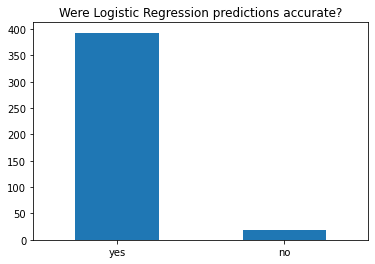

In [65]:
# visualize model accuracy in bar chart
logR_accurate_counts.plot.bar(rot = 0, title = 'Were Logistic Regression predictions accurate?')

## RANDOM FOREST CLASSIFIER

In [66]:
# fit random forest classifier model to xtrain scaled & ytrain, check model accuracy against training dataset and test dataset
clf = RandomForestClassifier(random_state=1, n_estimators=500).fit(X_train_scaled, y_train)
print(f'Random Forest Classifier Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Random Forest Classifier Testing Score: {clf.score(X_test_scaled, y_test)}')

Random Forest Classifier Training Score: 1.0
Random Forest Classifier Testing Score: 0.941747572815534


In [67]:
# create confusion matrix
y_true = y_test
y_pred = clf.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[ 17,  18],
       [  6, 371]], dtype=int64)

In [68]:
# create classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.49      0.59        35
           1       0.95      0.98      0.97       377

    accuracy                           0.94       412
   macro avg       0.85      0.73      0.78       412
weighted avg       0.94      0.94      0.94       412



[0.09700702 0.10663628 0.08767748 0.13345431 0.12381608 0.01784962
 0.04778202 0.02338853 0.01720319 0.03111964 0.01975433 0.02593077
 0.01979212 0.01992694 0.02313857 0.01818517 0.03296874 0.07178477
 0.07937552 0.00092309 0.00228581]


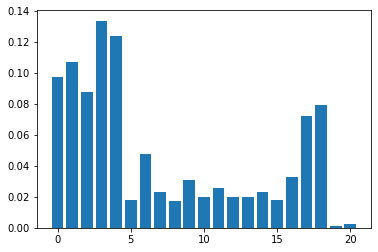

In [69]:
# Save the feature importances from the Random Forests classifier model to a variable named feature_importances
features = clf.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

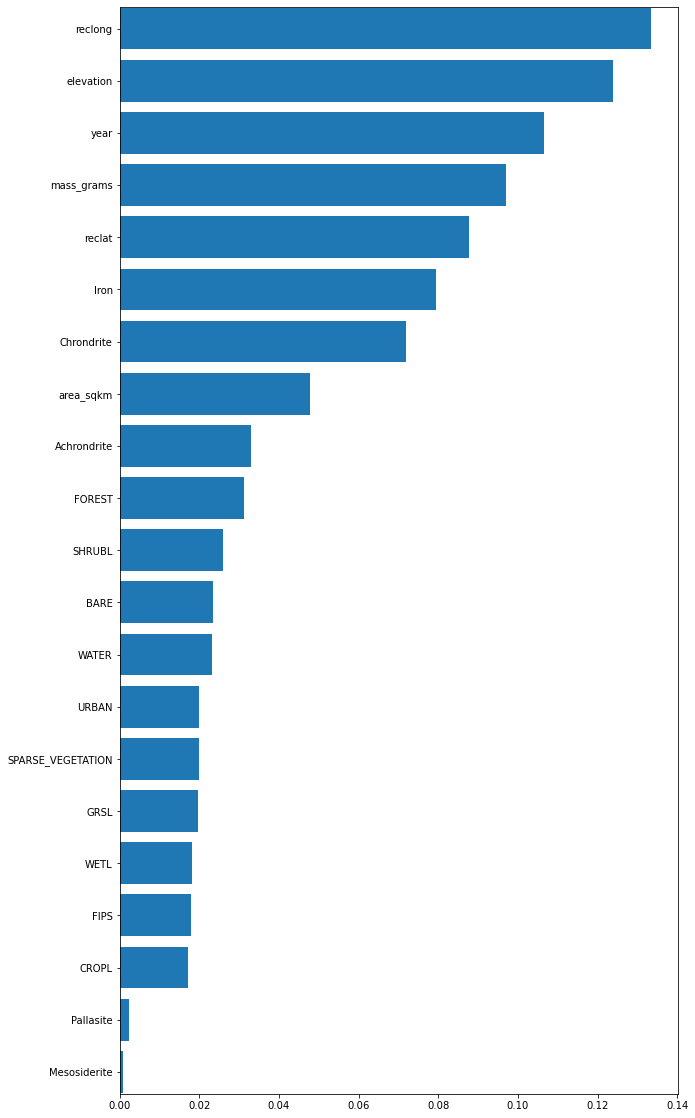

In [70]:
# Use the following code to plot the most important features
features = sorted(zip(X.columns, features), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,20)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

# K Nearest Neighbors

In [71]:
# check input df
print(len(ml_unscaled))
ml_unscaled.head()

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
2,10600.0,0,1921,44.51667,-83.95000,387.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
3,1551.0,0,1997,42.38467,-83.61150,279.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
4,51700.0,1,1883,42.96667,-85.76667,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,0,1,0,0


In [72]:
# create X df
X = ml_unscaled.drop('fall',axis =1)
print(len(X))
X.head()

1648


,mass_grams,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,FOREST,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
2,10600.0,1921,44.51667,-83.95000,387.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
3,1551.0,1997,42.38467,-83.61150,279.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
4,51700.0,1883,42.96667,-85.76667,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,0,1,0,0


In [73]:
# create y series
y = ml_unscaled['fall'].values

In [74]:
# split data into xtrain and ytrain
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler()
X_scaler.fit(X_train)

# Transform the training and testing data by using the X_scaler and y_scaler models
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 1.000/0.925
k: 3, Train/Test Score: 0.958/0.939
k: 5, Train/Test Score: 0.946/0.949
k: 7, Train/Test Score: 0.943/0.956
k: 9, Train/Test Score: 0.946/0.956
k: 11, Train/Test Score: 0.943/0.956
k: 13, Train/Test Score: 0.941/0.956
k: 15, Train/Test Score: 0.941/0.959
k: 17, Train/Test Score: 0.941/0.961
k: 19, Train/Test Score: 0.937/0.949


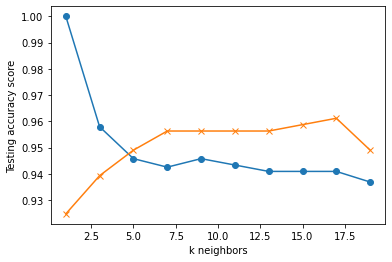

In [75]:
# Loop through different k values to find which has the highest accuracy.
# Note: We use only odd numbers because we don't want any ties.
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy score")
plt.show()

In [76]:
# K = 17 Note that k: 17 returns highest precision for test set, but k:5 would be selected based on elbow chart
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train_scaled, y_train)
print('k=17 Test Acc: %.3f' % knn.score(X_test_scaled, y_test))

k=17 Test Acc: 0.961


In [77]:
# K = 5  Note that k: 17 returns highest precision for test set, but k:5 would be selected based on elbow chart
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(X_train_scaled, y_train)
print('k=5 Test Acc: %.3f' % knn2.score(X_test_scaled, y_test))

k=5 Test Acc: 0.949


In [78]:
# k = 17 create inputs and run confusion matrix [TrueNegative(25),FalsePositive(10)],[FalseNegative(6),TruePositive(371)]
y_true = y_test
y_pred = knn.predict(X_test_scaled)
confusion_matrix(y_true, y_pred)

array([[ 25,  10],
       [  6, 371]], dtype=int64)

In [79]:
# k = 5 create inputs and run confusion matrix [TrueNegative(),FalsePositive()],[FalseNegative(),TruePositive()]
y_true2 = y_test
y_pred2 = knn2.predict(X_test_scaled)
confusion_matrix(y_true2, y_pred2)

array([[ 19,  16],
       [  5, 372]], dtype=int64)

In [80]:
# K = 17 create classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76        35
           1       0.97      0.98      0.98       377

    accuracy                           0.96       412
   macro avg       0.89      0.85      0.87       412
weighted avg       0.96      0.96      0.96       412



In [81]:
# K = 5  create classification report
print(classification_report(y_true2, y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.54      0.64        35
           1       0.96      0.99      0.97       377

    accuracy                           0.95       412
   macro avg       0.88      0.76      0.81       412
weighted avg       0.94      0.95      0.94       412



# SUPPORT VECTOR CLASSIFIER

In [82]:
# set target
target = ml_unscaled["fall"]
target_names = ["fall", "found"]

In [83]:
# set data
data = ml_unscaled.drop("fall", axis=1)
feature_names = data.columns
data.head()

,mass_grams,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,FOREST,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
2,10600.0,1921,44.51667,-83.95000,387.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
3,1551.0,1997,42.38467,-83.61150,279.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
4,51700.0,1883,42.96667,-85.76667,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,0,1,0,0


In [84]:
# split data into train and test, scale x
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [85]:
# Support vector machine linear classifier (took 6 1/2 min with the fan running high)
model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

modelsc = SVC(kernel='linear', probability=True)
modelsc.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True)

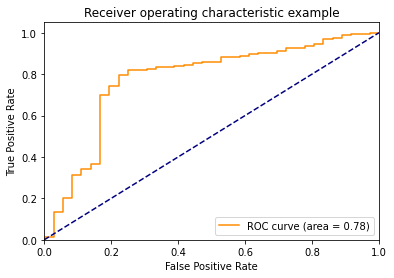

In [86]:
# plot ROC curve
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [87]:
# Model Accuracy and confusion matrix
print('Test Acc: %.3f' % model.score(X_test, y_test))
print('Scaled Test Acc: %.3f' % modelsc.score(X_test_scaled, y_test))
y_true = y_test
y_pred = model.predict(X_test)
cm = confusion_matrix(y_true, y_pred)
cm

Test Acc: 0.913
Scaled Test Acc: 0.947


array([[  3,  33],
       [  3, 373]], dtype=int64)

In [88]:
# classification report
predictions = model.predict(X_test)
print(classification_report(y_test, predictions,
                            target_names=target_names))

              precision    recall  f1-score   support

        fall       0.50      0.08      0.14        36
       found       0.92      0.99      0.95       376

    accuracy                           0.91       412
   macro avg       0.71      0.54      0.55       412
weighted avg       0.88      0.91      0.88       412



In [118]:
# Support vector machine rbf classifier
bmodel = SVC(kernel='rbf', probability=True)
bmodel.fit(X_train, y_train)

bmodelsc = SVC(kernel='rbf', probability=True)
bmodelsc.fit(X_train_scaled, y_train)

SVC(probability=True)

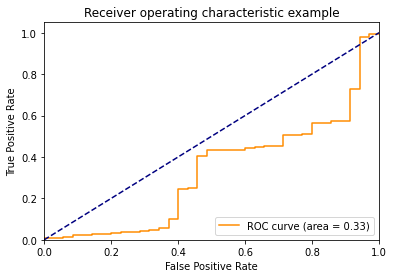

In [119]:
# plot ROC curve RBF
by_pred_prob = bmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, by_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [116]:
# Support vector machine rbf classifier
cmodel = SVC(kernel='sigmoid', probability=True)
cmodel.fit(X_train, y_train)

cmodelsc = SVC(kernel='sigmoid', probability=True)
cmodelsc.fit(X_train_scaled, y_train)

SVC(kernel='sigmoid', probability=True)

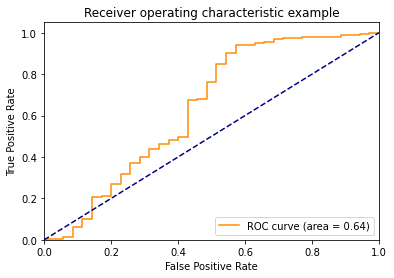

In [117]:
# plot ROC curve RBF  (with previous run of svc with sigmoid, area under roc curve was 0.36)
cy_pred_prob = cmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, cy_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [124]:
# Support vector machine rbf classifier
dmodel = SVC(kernel='poly', probability=True)
dmodel.fit(X_train, y_train)

dmodelsc = SVC(kernel='poly', probability=True)
dmodelsc.fit(X_train_scaled, y_train)

SVC(kernel='poly', probability=True)

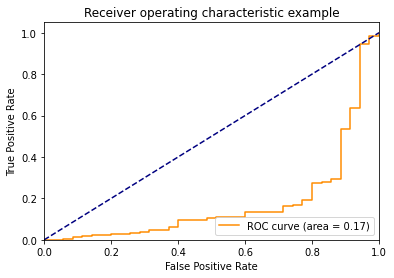

In [125]:
# plot ROC curve RBF  (1st & second poly runs roc 0.17)
dy_pred_prob = dmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, dy_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# LINEAR REGRESSION AND LASSO 

In [89]:
#  set x and y
X = ml_unscaled.drop(["fall"], axis=1)
y = ml_unscaled['fall']

In [90]:
# dataset has 20 features and 1648 samples
print(len(ml_unscaled))
ml_unscaled.head()

1648


,mass_grams,fall,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
2,10600.0,0,1921,44.51667,-83.95000,387.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
3,1551.0,0,1997,42.38467,-83.61150,279.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
4,51700.0,1,1883,42.96667,-85.76667,225.0,26,250487,0.241572,35.820019,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,0,1,0,0


In [91]:
# split data into test and train, scale x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [92]:
# fit linear regression model, print score
reg = LinearRegression().fit(X_train_scaled, y_train)
reg.score(X_test_scaled, y_test)

0.3367706412910496

In [93]:
# Select the columns that have a nonzero value from the LASSO regression.
reg = Lasso(max_iter=200).fit(X_train_scaled, y_train)
reg.score(X_test_scaled, y_test)

-0.0003031451307311528

'The main problem with lasso regression is when we have correlated variables, it retains only one variable and sets other correlated variables to zero. That will possibly lead to some loss of information resulting in lower accuracy in our model.'

https://www.mygreatlearning.com/blog/understanding-of-lasso-regression/#:~:text=The%20main%20problem%20with%20lasso,lower%20accuracy%20in%20our%20model.


# Extremely randomn trees

In [94]:
#  set x and y
X = ml_unscaled.drop(["fall"], axis=1)
y = ml_unscaled['fall']

In [95]:
# split into test/train, scale x
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [96]:
# fit extra trees classifier model, print train and test score
clf = ExtraTreesClassifier(random_state=1, n_estimators=50).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 0.9368932038834952


# Hierarchical Clustering

In [97]:
# remove fall from dataset (used during supervised learning)
hc_df = ml_unscaled.drop(['fall'], axis = 1)
print(len(hc_df))
hc_df.head()

1648


,mass_grams,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,FOREST,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,32000.0,1899,42.53333,-85.88333,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
1,469.0,1994,43.76111,-84.50778,218.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
2,10600.0,1921,44.51667,-83.95000,387.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
3,1551.0,1997,42.38467,-83.61150,279.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,1,0,0,0
4,51700.0,1883,42.96667,-85.76667,225.0,26,250487,0.241572,35.820019,52.486729,...,0.668927,0.026182,3.350872,2.644462,0.312346,0,0,1,0,0


In [98]:
# normalize dataset
normalized = normalize(hc_df)

In [99]:
# add column headers to normalized df and print
df2 = pd.DataFrame(normalized)
df2.columns = hc_df.columns
df2.head()

,mass_grams,year,reclat,reclong,elevation,FIPS,area_sqkm,BARE,CROPL,FOREST,...,SHRUBL,SPARSE_VEGETATION,URBAN,WATER,WETL,Achrondrite,Chrondrite,Iron,Mesosiderite,Pallasite
0,0.126718,0.007520,0.000168,-0.000340,0.000891,0.000103,0.991910,9.566089e-07,0.000142,0.000208,...,0.000003,1.036799e-07,0.000013,0.000010,0.000001,0.0,0.000004,0.000000,0.0,0.0
1,0.001872,0.007960,0.000175,-0.000337,0.000870,0.000104,0.999966,9.643784e-07,0.000143,0.000210,...,0.000003,1.045220e-07,0.000013,0.000011,0.000001,0.0,0.000004,0.000000,0.0,0.0
2,0.042278,0.007662,0.000178,-0.000335,0.001544,0.000104,0.999075,9.635192e-07,0.000143,0.000209,...,0.000003,1.044288e-07,0.000013,0.000011,0.000001,0.0,0.000004,0.000000,0.0,0.0
3,0.006192,0.007972,0.000169,-0.000334,0.001114,0.000104,0.999948,9.643613e-07,0.000143,0.000210,...,0.000003,1.045201e-07,0.000013,0.000011,0.000001,0.0,0.000004,0.000000,0.0,0.0
4,0.202132,0.007362,0.000168,-0.000335,0.000880,0.000102,0.979330,9.444769e-07,0.000140,0.000205,...,0.000003,1.023650e-07,0.000013,0.000010,0.000001,0.0,0.000000,0.000004,0.0,0.0


In [100]:
# Perform hierarchical clustering
mergings = linkage(normalized, method='ward')

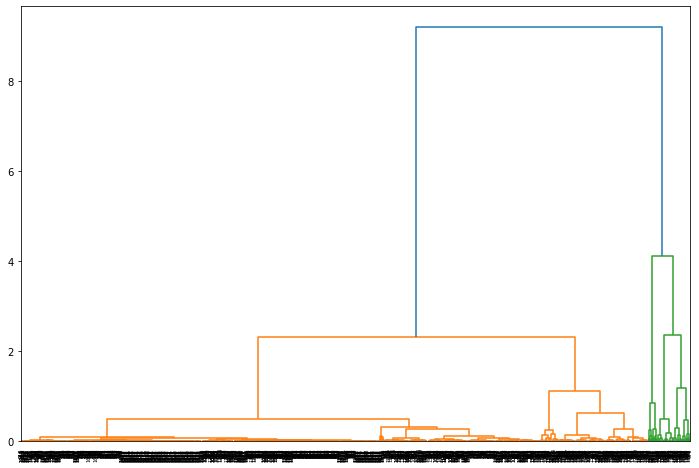

In [101]:
# Generate a dendrogram
plt.figure(figsize=(12,8))

dendrogram(mergings,
          leaf_rotation=90,
          leaf_font_size=5)

plt.show()

In [102]:
# Generate cluster labels with sklearn.cluster's AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2,
                                 affinity='euclidean',
                                 linkage='ward')
labels = cluster.fit_predict(df2)

In [103]:
# list df2 columns
df2.columns

Index(['mass_grams', 'year', 'reclat', 'reclong', 'elevation', 'FIPS',
       'area_sqkm', 'BARE', 'CROPL', 'FOREST', 'GRSL', 'SHRUBL',
       'SPARSE_VEGETATION', 'URBAN', 'WATER', 'WETL', 'Achrondrite',
       'Chrondrite', 'Iron', 'Mesosiderite', 'Pallasite'],
      dtype='object')

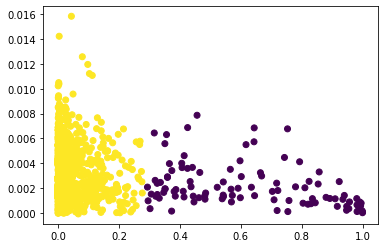

In [104]:
# Create a scatter plot with two of the features
plt.scatter(df2['mass_grams'], df2['elevation'], c=labels)
plt.show()

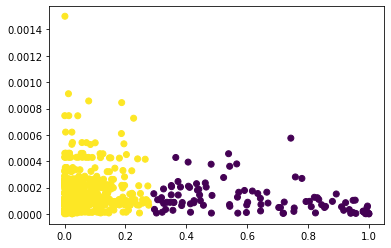

In [105]:
# Create a scatter plot with two of the features
plt.scatter(df2['mass_grams'], df2['FIPS'], c=labels)
plt.show()